# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [3]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [4]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

## Dataset
The dataset used for this project is the dog breed dataset. It contains 133 different breeds of dogs. The dataset is split into a training set, a validation set and a test set. The training set contains 6680 images, the validation set contains 835 images and the test set contains 836 images. The images are of different sizes and are in color. The images are in the format of jpg.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip


--2023-06-26 07:28:46--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.40
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  39.2MB/s    in 46s     

2023-06-26 07:29:34 (23.3 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [ ]:
!aws s3 cp dogImages s3://bucketdogbreed/ --recursive

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://bucketdogbreed/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://bucketdogbreed/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://bucketdogbreed/test/001.Affenpinscher/Affenpinscher_00048.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00139.jpg to s3://bucketdogbreed/test/002.Afghan_hound/Afghan_hound_00139.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://bucketdogbreed/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg to s3://bucketdogbreed/test/001.Affenpinscher/Affenpinscher_00071.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://bucketdogbreed/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00116.

## Global variables

In [16]:
BUCKET = 'bucketdogbreed'

os.environ['SM_CHANNEL_TRAINING']=f's3://{BUCKET}/'
os.environ['SM_MODEL_DIR']=f's3://{BUCKET}/model/'
os.environ['SM_OUTPUT_DATA_DIR']=f's3://{BUCKET}/output/'

data_channels = {
    "train": "s3://{}/train/".format(BUCKET),
    "test": "s3://{}/test/".format(BUCKET),
    "valid": "s3://{}/valid/".format(BUCKET)
}

role = sagemaker.get_execution_role()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [14]:
hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 32, 64, 128, 256, 512]),
    "early-stopping-rounds": CategoricalParameter([10, 12, 15, 17, 20])
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: (\d+\.\d+)"}]

In [ ]:
#TODO: Declare your HP ranges, metrics etc.


In [15]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="HP",
    role=role,
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version="py3",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [20]:
# TODO: Fit your HP Tuner
tuner.fit({"training": f"s3://{BUCKET}/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
..............................................................................................................................................................................................................!


In [21]:
best_estimator = tuner.best_estimator()
print(best_estimator.hyperparameters())

hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "learning-rate": best_estimator.hyperparameters()['learning-rate'],
                   "early-stopping-rounds": int(best_estimator.hyperparameters()['early-stopping-rounds'].replace('"', ''))
                  }
hyperparameters


2023-06-27 05:41:24 Starting - Found matching resource for reuse
2023-06-27 05:41:24 Downloading - Downloading input data
2023-06-27 05:41:24 Training - Training image download completed. Training in progress.
2023-06-27 05:41:24 Uploading - Uploading generated training model
2023-06-27 05:41:24 Completed - Resource released due to keep alive period expiry
{'_tuning_objective_metric': '"Test Loss"', 'batch-size': '"32"', 'early-stopping-rounds': '"15"', 'learning-rate': '0.003280776025933873', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"HP-2023-06-27-05-24-29-813"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-063444600624/HP-2023-06-27-05-24-29-813/source/sourcedir.tar.gz"'}


{'batch-size': 32,
 'learning-rate': '0.003280776025933873',
 'early-stopping-rounds': 15}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [23]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [24]:
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="MAIN",
    role=role,
    instance_count=2,
    instance_type="ml.g4dn.xlarge",
    framework_version="1.8.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
estimator.fit({"training": f"s3://{BUCKET}/"})

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: MAIN-2023-06-27-07-56-12-699


2023-06-27 07:56:13 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-06-27 07:57:01 Starting - Preparing the instances for training...
2023-06-27 07:57:41 Downloading - Downloading input data......
2023-06-27 07:58:42 Training - Downloading the training image..................
2023-06-27 08:01:43 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-27 08:01:35,182 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-27 08:01:35,211 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-06-27 08:01:35,215 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-06-27 08:01:35,486 sagemaker-training-toolkit INFO 

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Debugging Output

In [ ]:
# TODO: Display the profiler output


In [25]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
description

{'TrainingJobName': 'MAIN-2023-06-27-07-56-12-699',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:063444600624:training-job/MAIN-2023-06-27-07-56-12-699',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-063444600624/MAIN-2023-06-27-07-56-12-699/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '32',
  'early-stopping-rounds': '15',
  'learning-rate': '"0.003280776025933873"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"MAIN-2023-06-27-07-56-12-699"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-063444600624/MAIN-2023-06-27-07-56-12-699/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8.0-gpu-py3',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTimeSeries': True},
 'RoleArn': 'arn:

In [26]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-06-27 08:47:25.725 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:368 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-06-27 08:47:25.764 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:368 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-063444600624/MAIN-2023-06-27-07-56-12-699/debug-output


In [27]:
trial.tensor_names()

[2023-06-27 08:47:39.884 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:368 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-06-27 08:47:40.903 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:368 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [28]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))


48

In [29]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))


3

In [30]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    print(f"[INFO] Getting data in {len(steps)} steps")
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
        print(".", end="")
    return steps, vals

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(20, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

INFO:matplotlib.font_manager:generated new fontManager


[INFO] Getting data in 48 steps
................................................loaded TRAIN data
[INFO] Getting data in 3 steps
...loaded EVAL data
completed TRAIN plot
completed EVAL plot


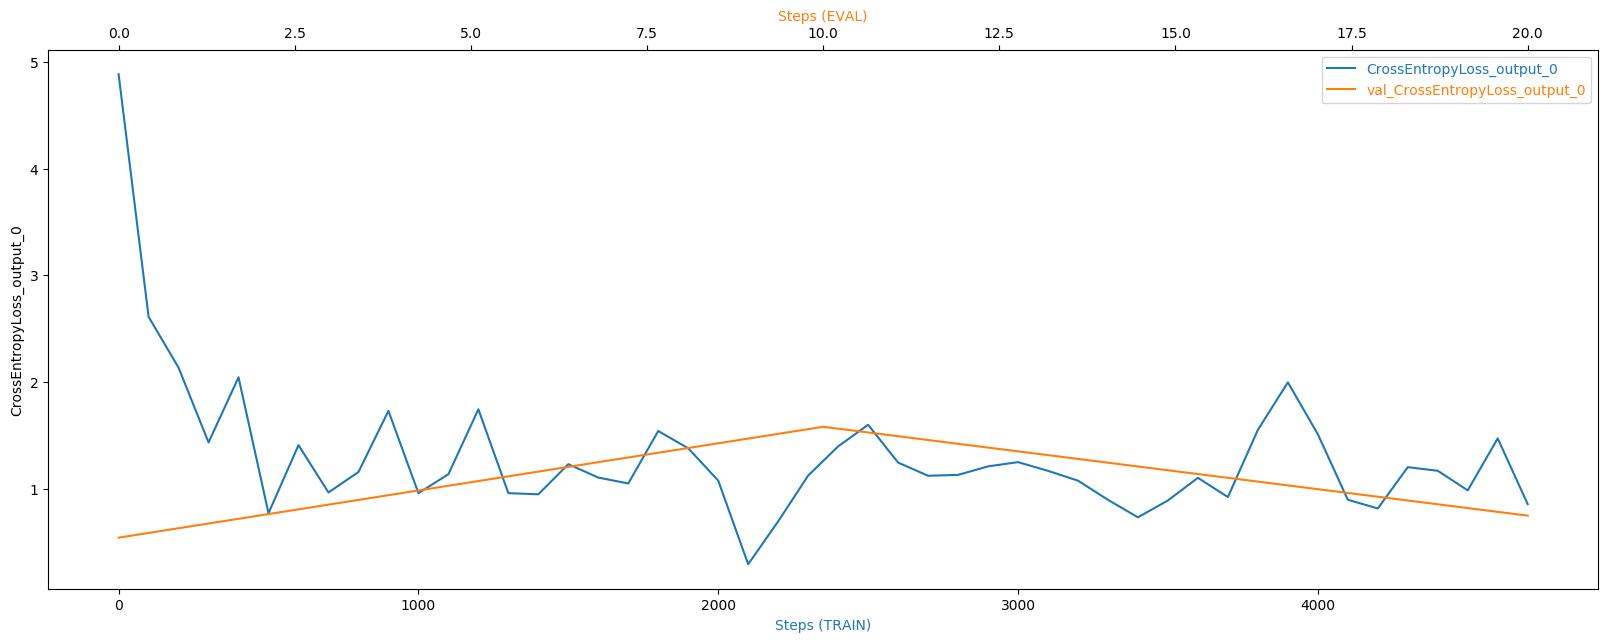

In [32]:
plot_tensor(trial, "CrossEntropyLoss_output_0")


### Profiler output

In [33]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"


In [34]:
! aws s3 ls {rule_output_path} --recursive


2023-06-27 08:35:09     501906 MAIN-2023-06-27-07-56-12-699/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-06-27 08:35:08     371687 MAIN-2023-06-27-07-56-12-699/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-06-27 08:35:02        903 MAIN-2023-06-27-07-56-12-699/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-06-27 08:35:02      78188 MAIN-2023-06-27-07-56-12-699/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-06-27 08:35:02       2037 MAIN-2023-06-27-07-56-12-699/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-06-27 08:35:02        492 MAIN-2023-06-27-07-56-12-699/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-06-27 08:35:02       2219 MAIN-2023-06-27-07-56-12-699/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2023-06-27 08:35:02        548 MAIN-2023-06-27-07-56-12-699/

In [35]:
! aws s3 cp {rule_output_path} ./ --recursive


download: s3://sagemaker-us-east-1-063444600624/MAIN-2023-06-27-07-56-12-699/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-063444600624/MAIN-2023-06-27-07-56-12-699/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-063444600624/MAIN-2023-06-27-07-56-12-699/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-063444600624/MAIN-2023-06-27-07-56-12-699/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-063444600624/MAIN-2023-06-27-07-56-12

In [36]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [37]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [38]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [39]:
pytorch_model = PyTorchModel(model_data=estimator.model_data, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [40]:
# TODO: Deploy your model to an endpoint

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-063444600624/MAIN-2023-06-27-07-56-12-699/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-063444600624/pytorch-inference-2023-06-27-10-09-10-630/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-06-27-10-09-20-810
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-06-27-10-09-21-559
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-06-27-10-09-21-559


-----!

In [41]:
import requests
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

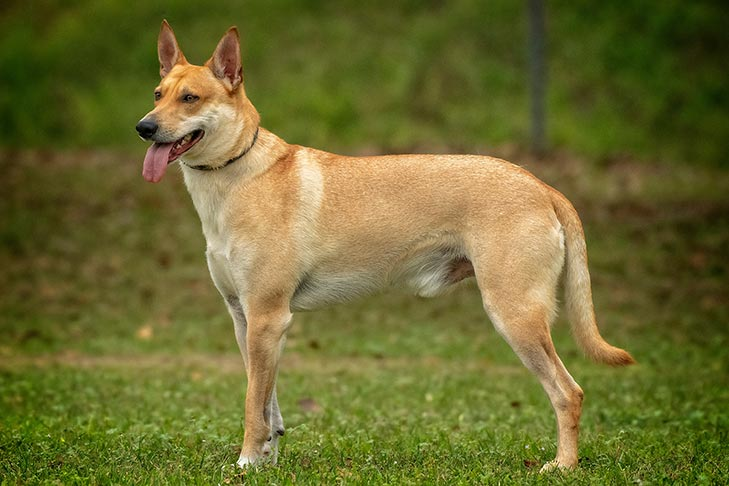

In [42]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [43]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [44]:
import numpy as np
np.argmax(response)

19

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()